<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Viewdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import/下載

In [ ]:
!pip install tqdm
!pip install kora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.5 MB/s eta 0:00:00


In [ ]:
import nibabel as nib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import widgets
import pandas as pd
import os
import torch

In [ ]:
from kora.xattr import get_id
import asyncio
import aiohttp
import nest_asyncio
from tqdm.asyncio import tqdm
nest_asyncio.apply()
loop = asyncio.get_event_loop()

In [ ]:
async def download_file(session, name, file_id, file_path, token):
  if not file_id:
    print(f"未找到文件: {name}")
    return

  download_url = f"https://www.googleapis.com/drive/v3/files/{file_id}?alt=media"
  headers = {"Authorization": f"Bearer {token}"}

  async with session.get(download_url, headers=headers) as response:
    if response.status == 200:
      with open(file_path, 'wb') as f:
        while True:
          chunk = await response.content.read(1024)
          if not chunk:
            break
          f.write(chunk)
      # print(f"Downloaded: {name}...")
    else:
      print(f"Failed: {name}!! status: {response.status}")


# 定义异步获取数据的主函数
async def get_data_disk_async(driveroot, targetdir, token):
  # 生成文件夹的绝对路径
  drive_folder_path = os.path.join(driveroot, targetdir)
  local_folder_path = os.path.join('/content', targetdir)

  if not os.path.exists(local_folder_path):
    os.makedirs(local_folder_path)
    print(f"making {targetdir} dir...")

  # 获取文件列表
  files_on_drive = os.listdir(drive_folder_path)
  files_in_localdir = os.listdir(local_folder_path)
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(os.path.join(drive_folder_path, filename))) for filename in files_to_download]

  async with aiohttp.ClientSession() as session:
    tasks = []
    for idx, (name, file_id) in enumerate(files):
      local_file_path = os.path.join(local_folder_path, name)
      task = asyncio.create_task(download_file(session, name, file_id, local_file_path, token))
      tasks.append(task)

    # 使用 tqdm 包装任务列表以显示进度条
    for f in tqdm.as_completed(tasks, total=len(tasks)):
      await f

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_rootdir = "/content/drive/MyDrive/AOCR2024"
labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'
submitpath = '/content/drive/MyDrive/AOCR2024/sample_submission.csv'
datadir ="Train_Valid_Image"
# datadir ="Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped"
testdir = "Test_Image"

In [ ]:
import io
import googleapiclient.discovery
from google.auth.exceptions import TransportError
from google.oauth2.service_account import Credentials
from googleapiclient.http import MediaIoBaseDownload

DriveAPIcredentials = r"/content/drive/MyDrive/AOCR2024/creds/appendicitis-407217-c2f141040794.json"
credentials = Credentials.from_service_account_file(DriveAPIcredentials,scopes=["https://www.googleapis.com/auth/drive"])
drive_service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

## Train/Valid

In [ ]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, datadir,token = credentials.token))

making Train_Valid_Image dir...


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]


In [ ]:
len(os.listdir(datadir))

1000

## Test

In [ ]:
from google.auth.transport.requests import Request
request = Request()
credentials.refresh(request)
loop.run_until_complete(get_data_disk_async(drive_rootdir, testdir,token = credentials.token))

making Test_Image dir...


100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


In [ ]:
len(os.listdir(testdir))


200

In [ ]:
cd /content/drive/MyDrive/AOCR2024/


/content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024


# 查看mask


試畫mask


In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import nibabel as nib

def update_plot(slice_number):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20, 20)
    axs[0].set_title(f'Slice Number: {slice_number}')

    axs[0].imshow(mydata[:, :, slice_number], cmap='gray')
    axs[0].imshow(mymask[:, :, slice_number], cmap='Reds', alpha=0.5)
    axs[1].imshow(mydata[:, :, slice_number], cmap='gray')

    for ax in axs:
        ax.axis('off')

    plt.show()

# Load your data
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii.gz')
mydata = nii_file.get_fdata()
nii_file = nib.load('Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628_label.nii.gz')
mymask = nii_file.get_fdata()

# Create a slider widget
slider = widgets.IntSlider(
    value=27,
    min=0,
    max=89,
    step=1,
    description='Slice:'
)


# Link the slider to the update function
widgets.interactive(update_plot, slice_number=slider)


(100.0, 300.0)

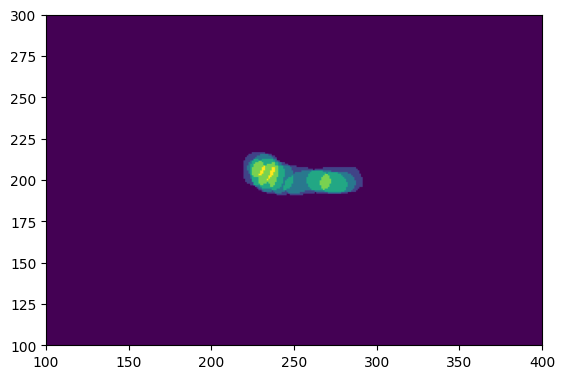

In [ ]:
plt.imshow(mymask.sum(axis=2))
plt.xlim((100, 400))
plt.ylim((100, 300))

## 有數據Size不同!
ZxA6E61E4E15A62519AAAE723617782AB9F2DA93CAAE5A0219.nii

In [ ]:
# 读取nii文件
nii_file = nib.load('ZxA6E61E4E15A62519AAAE723617782AB9F2DA93CAAE5A0219.nii')
mydata = nii_file.get_fdata()

mydata.shape


(533, 512, 108)

# interactive and millimeter

In [ ]:
!pip install ipympl
%matplotlib ipympl

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import nibabel as nib

traindir = "Train_Valid_Image"


def update_plot(slice_number):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    ax.set_title(f'Slice Number: {slice_number}')
    ax.imshow(mydata[:, :, slice_number], cmap='gray')
    ax.axis('off')

    plt.show()

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

slider = widgets.IntSlider(
    value=27,
    min=0,
    max=89,
    step=1,
    description='Slice:'
)

# Load your data
nii_file = nib.load(f'{traindir}/Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii.gz')
mydata = nii_file.get_fdata()
mydata = np.rot90(mydata)
widgets.interactive(update_plot, slice_number=slider)


# voxel_coords = np.array([x, y, z, 1])  # Replace x, y, z with your voxel coordinates
# real_world_coords = affine @ voxel_coords
# print("Real World Coordinates:", real_world_coords[:3])




interactive(children=(IntSlider(value=27, description='Slice:', max=89), Output()), _dom_classes=('widget-inte…

140.1337662337662 354.1320363230519
144.7883116883117 254.61342075892856


In [ ]:

hdr = nii_file.header
print(hdr.get_zooms())
print(hdr.get_data_shape())
print(hdr.get_xyzt_units())



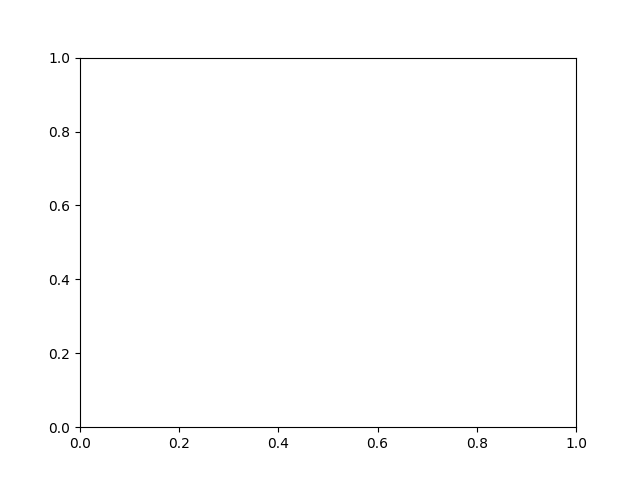

0.4616935483870968 0.6553030303030303
0.21975806451612906 0.5254329004329004
0.10483870967741937 0.37662337662337664
0.11088709677419356 0.7851731601731601
0.24596774193548387 0.7283549783549783


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print(ix, iy)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

# 圖

In [ ]:
path = os.path.join(datadir,'Zx29D944DDC12D73E641FD78628DA3CCDAD0CCD13F9C098056.nii.gz')
nii_file = nib.load(path)
mydata = nii_file.get_fdata()

In [ ]:
mydata[:,:,20].max()

1086.0

# Max/Min/Avg pooling

In [ ]:
def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df

def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """

  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df


def read_data(directory, shift=0, termi=10) -> dict[str, np.array]:
    """Reads all the .nii.gz files in a given directory and returns a dictionary.

    The dictionary keys are the file names without the .nii extension. The dictionary
    values are the corresponding numpy arrays.

    Args:
      directory: The directory containing the .nii files.
      shift: The number of files to skip at the beginning of the directory.
      termi: The number of files to be read in the directory.

    Returns:
      A dictionary of numpy arrays.
    """

    data_dict = {}
    k = 0
    ncut = 0
    filelist = os.listdir(directory)
    # filelist = ['Zx247C48E8B7D1EABBA1DEF5CD4AC1D8E8ACAFA8C759A85107.nii.gz',
    #       'ZxA9699F56C35B1D82E9703F233BD3208C31BEBE3E7907731A.nii.gz',
    #        'ZxFE087EAB297CA731B8DBD01407C31C992274CA97F8770F37.nii.gz'] #不滿60張
    for afile in filelist:
      if afile.endswith('.nii.gz'):
        if (k<shift):
          k += 1
          continue
        file_path = os.path.join(directory, afile)
        nii_file =  nib.load(file_path)
        data = nii_file.get_fdata()
        data_dict[afile.strip('.nii.gz')] = data
        ncut +=  1
        if ncut == termi:
          return data_dict
    return data_dict



def process_data(data:dict, dfref:pd.DataFrame)\
 -> tuple[torch.tensor, torch.tensor, list[tuple[str, int]]]:
  """Process the data, get the id and number of each scan, and merge the images and labels.

  Args:
      data: The data of the scans
      labels: The labels of the scans

  Returns:
      A tuple of images, labels, and (id, # of cuts) of each scan
  """

  # 每個scan的id與數量
  # 圖片與對應label的tesnor
  images_list = []
  labels_list = []
  ids_list = []
  k = 0
  if dfref.index.name != 'id':
    dfref.set_index('id', inplace=True)
  for key, value in data.items():
    scan  = dfref.loc[dfref.index.str.startswith(key+'_')]
    # scan = scan.iloc[11:71, :] #只拿第11列~第70列! 不滿60張的全拿完. 要是讀取沒cropeed注釋掉
    labels = np.array(scan['label'])
    ids = scan.index.to_list()

    images_t = torch.from_numpy(value).float().permute(2, 0, 1)
    labels_t = torch.from_numpy(labels)
    images_list.append(images_t)
    labels_list.append(labels_t)
    ids_list.extend(ids)
    k += 1
    print(f"read the {k} scans")

  # 合併
  images = torch.cat(images_list, dim=0)
  labels = torch.cat(labels_list, dim=0)

  return images, labels.float(), ids_list

In [ ]:
#注意有無cropped 要去process_data裡修改!!!


batch = 25
total = 200

path = os.path.join(drive_rootdir,'images_statistics')
os.makedirs(path, exist_ok=True)

dflabel = read_label(labelpath)
dfsubmission = read_submission(submitpath)

data = []
for start in range(0,total,batch):
  print(f"{start=}")
  # datadict = read_data(datadir, shift=start, termi=batch)
  # images, labels, ids = process_data(datadict, dflabel) #輸出訓練集資訊

  datadict = read_data(testdir, shift=start, termi=batch)
  images, labels, ids = process_data(datadict, dfsubmission) #輸出測試集資訊

  for i in range(images.shape[0]):
      img = images[i]
      img_min = img.min().item()
      img_max = img.max().item()
      img_avg = img.mean().item()

      data.append([ids[i], labels[i].item(), img_max, img_min, img_avg])

    #列表轉dataFrame
df = pd.DataFrame(data, columns=['ID', 'Label', 'Max', 'Min','Avg'])

# 將 DataFrame 保存到 CSV 檔案
name = input("輸入儲存檔名")
df.to_csv(os.path.join(path,name)+'.csv', index=False)

# others


In [38]:
import torch
import torch.nn as nn

# 創建一個示例張量
x = torch.randint(1,50, (1,3,3))

# 定義 MaxPool 池化層
maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)

# 應用 MaxPool
y = maxpool_1(x)
y1 = maxpool_2(y)

print(x)
print(y)
print()
print(y1)
print()


tensor([[[32, 13, 11],
         [15,  8, 35],
         [11, 41, 16]]])
tensor([[[32, 35],
         [41, 41]]])

tensor([[[41]]])



In [30]:
x

tensor([[6, 5, 2],
        [2, 6, 8],
        [1, 8, 2]])

In [40]:
x = torch.randint(1,20, (1,3,3))
# 定義 MinPool 池化層（使用 MaxPool）
minpool_1 = lambda x: -nn.MaxPool2d(kernel_size=2, stride=1)(-x)
minpool_2 = lambda x: -nn.MaxPool2d(kernel_size=2, stride=1)(-x)

# 應用 MinPool
z1 = minpool_1(x)
z2 = minpool_2(z1)
print(x)
print()
print(z1)
print()
print(z2)


tensor([[[13,  1, 11],
         [ 4,  2,  5],
         [12,  1, 18]]])

tensor([[[1, 1],
         [1, 1]]])

tensor([[[1]]])


In [41]:
x = torch.randint(1,20, (1,3,3))
# 定義 AvgPool 池化層
avgpool_1 = nn.AvgPool2d(kernel_size=2, stride=1)
avgpool_2 = nn.AvgPool2d(kernel_size=2, stride=1)

# 應用 AvgPool
w1 = avgpool_1(x)
w2 = avgpool_2(w1)
print(x)
print()
print(w1)
print()
print(w2)


tensor([[[15, 18, 19],
         [10, 19,  7],
         [ 5,  8, 16]]])

tensor([[[15, 15],
         [10, 12]]])

tensor([[[13]]])


In [ ]:
drive.flush_and_unmount()

In [60]:
import pandas as pd
df1 = pd.DataFrame({'a': ['foo', 'bar'], 'b': [1, 2]}).set_index('a')
df2 = pd.DataFrame({'a': ['foo'], 'b': [3]}).set_index('a')

In [61]:
print(df1)
print()
print(df2)

     b
a     
foo  1
bar  2

     b
a     
foo  3


In [63]:
df1.merge(df2, how='outer', left_on='a', right_on='a')

,b_x,b_y
a,,
foo,1,3.0
bar,2,NaN
